In [6]:
#Importing
import os
import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LeakyReLU
from IPython.display import clear_output, display

from collections import deque

### Neural Network

In [20]:
## Creating Deep-Q network
def q_network(numInput, numHidden, numHiddenLayers, numOutput, optimiserFunction=tf.train.AdamOptimizer, \
              alpha=0.00025, lossFunction="mse", hiddenActivation="relu", outputActivation="linear"): 
    
    #Creating a TensorFlow class
    network = Sequential()
    
    #Creating first hidden layer
    network.add(Dense(numHidden, input_dim=numInput, activation=hiddenActivation))
    
    #Adding 'n' hidden layers
    for _ in range(numHiddenLayers):
        network.add(Dense(numHidden, activation=hiddenActivation))
        
    #Creating output layer
    network.add(Dense(numOutput, activation=outputActivation))
    #network.add(Dense(numOutput, activation=LeakyReLU(alpha=0.1)))
    
    #Defining the loss function, the optimiser and the metrics.
    network.compile(loss=lossFunction, optimizer=Adam(lr=alpha))
    
    return network   

### Memory

In [9]:
class memory():
    def __init__(self, maxSize=2000):
        self.memory_buffer = deque(maxlen=2000)
        self.memory_rewards = []
        
    def add(self, state, action, reward, state_prime, done):
        self.memory_buffer.append((state, action, reward, state_prime, done))
        self.memory_rewards.append(reward)
        
    def getBuffer(self):
        return self.memory_buffer
    
    def getRewards(self):
        return self.memory_rewards
    
    def resetRewards(self):
        self.memory_rewards = []

### Agent

In [32]:
class rocketMan():
    def __init__(self, numInput, numHidden, numHiddenLayers, numOutput, \
                 alpha=0.0001, gamma=0.99, epsilon=1.0, epsilonEnd=0.01, epsilonDecay=0.995, batchSize=16):
    
        self.network = q_network(numInput, numHidden, numHiddenLayers, numOutput)
        self.targetNetwork = q_network(numInput, numHidden, numHiddenLayers, numOutput)
        
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilonEnd = epsilonEnd
        self.epsilonDecay = epsilonDecay
        self.batchSize = batchSize
                            
        self.reply = memory(2000)
        
        ### Add load/save later
        
    def getAction(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return(env.action_space.sample())
        else:
            return(np.argmax(self.network.predict(state.reshape(1,-1))[0])) 
        
    def addMemory(self, state, action, reward, state_prime, done):
        self.reply.add(state, action, reward, state_prime, done)
        
    def soft_target_weight_update(self, tau):
        weights = np.asarray(self.network.get_weights())
        target_weights = np.asarray(self.targetNetwork.get_weights())
        self.targetNetwork.set_weights( (weights * tau) + (target_weights * (1 - tau)))
        
    def train(self):
        if(len(self.reply.getBuffer()) >= self.batchSize):        
            #Randomly picking 'batch_size' samples from reply list
            randomSample = random.sample(self.reply.getBuffer(), self.batchSize)

            #Looping through the given observation
            for state, action, reward, state_prime, done in randomSample:
                '''
                if not done:
                    temp_prediction = self.network.predict(state_prime.reshape(1,-1))
                    target = ((1-self.alpha) * reward) + self.alpha * (self.gamma * np.max(temp_prediction[0]))
                else:
                    target = reward

                targetOld = self.network.predict(state.reshape(1,-1))
                targetOld[0][action] = target

                #Fitting the network
                self.network.fit(x=state.reshape(1,-1), y=targetOld, batch_size=self.batchSize, epochs=1, verbose=0)
                '''
                q_values = self.network.predict(state.reshape(1,-1))
                target_q_values = q_values

                if done == True: 
                    target_q_values[0][action] = reward
                else: 
                    target_q_values[0][action] = reward + (self.gamma * np.max(self.targetNetwork.predict(state_prime.reshape(1,-1))) )

                self.network.fit(state.reshape(1,-1), target_q_values, batch_size=self.batchSize, verbose=0)
            self.soft_target_weight_update(0.5)

### Training

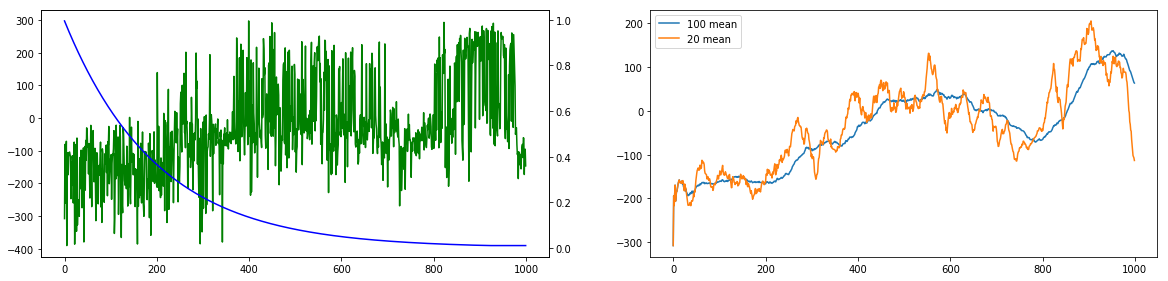

RT:  3454.170884954001


In [36]:
numEpisodes = 1000
minReward = -300 #If the sum reward drops below this, stop

#Repeatablilty
seed = 32

#Loading the gym environment
env = gym.make('LunarLander-v2')

# Set seed for PRN generator of numpy, random module and gym env.
np.random.seed(seed)
random.seed(seed)
env.seed(seed)

numInput = env.observation_space.shape[0]
numActions = env.action_space.n

#Number of hidden neurons and layers0
numHidden = 128
numHiddenLayers = 1 #Already has a hidden layer, so 1 is actually 2 hidden (must change this)

#Creating agent (rocketMan)
rocketManAgent = rocketMan(numInput, numHidden, numHiddenLayers, numActions)

#Information for plotting
rewardList = []
meanRewards = []
meanRewards1 = []
epsilonList = []
scores_window = deque(maxlen=100)
scores_window1 = deque(maxlen=20)

from timeit import default_timer as timer

start = timer()

for episodeNum in range(numEpisodes):
    state = env.reset()
    
    step = 0
    while True:        
        chosenAction = rocketManAgent.getAction(state)
        
        #Taking action in environemnt
        state_prime, reward, done, info = env.step(chosenAction)
        
        #Adding the state information to the reply buffer
        rocketManAgent.reply.add(state, chosenAction, reward, state_prime, done)
        
        state = state_prime
        
        episode_rewards = np.sum(rocketManAgent.reply.getRewards())
        
        step += 1
        
        if(step % 16) == 0:
            rocketManAgent.train()
        
        if(episode_rewards < minReward):
            done = True
            
        if done == True:
            rocketManAgent.train()
            
            #Updating epsilon
            if rocketManAgent.epsilon >= rocketManAgent.epsilonEnd:
                rocketManAgent.epsilon *= rocketManAgent.epsilonDecay   
            
            rewardList.append(episode_rewards)
            epsilonList.append(rocketManAgent.epsilon)
            scores_window.append(episode_rewards)
            scores_window1.append(episode_rewards)
            
            meanRewards.append(np.mean(scores_window))
            meanRewards1.append(np.mean(scores_window1))
            
            clear_output(wait=True)
            
            plt.figure(figsize=(20, 10))
            ax = plt.subplot(2,2,1)
            ax2 = ax.twinx()
            ax.plot(range(episodeNum+1), rewardList, 'g-')
            ax2.plot(range(episodeNum+1), epsilonList, 'b-')

            ax = plt.subplot(2,2,2)
            ax.plot(range(len(meanRewards)), meanRewards, label="100 mean")
            ax.plot(range(len(meanRewards1)), meanRewards1, label="20 mean")
            plt.legend()
            plt.show()                      
            
            #Resetting epsiode rewards
            rocketManAgent.reply.resetRewards()
            
            break
            
end = timer()
print("RT: ", (end - start))